# Experiment : Frozen Noise Classification

In this experiment, the simulator will be used to classify two random frozen noise patterns

### Imports

In [1]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

from typing import Optional, Tuple, Any

# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Jax Imports
from jax import random as rand
from jax import numpy as jnp

from rockpool.devices.dynapse import (
    DynapSim,
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    find_dynapse_boards,
    DynapseSamna,
    dynapse_mismatch_generator,
)

from rockpool.nn.modules.module import ModuleBase
from utils import FrozenNoiseDataset, plot_Ix

# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


# Step 1 : Input 

In [2]:
train_data = FrozenNoiseDataset(2)
test_data = FrozenNoiseDataset(10, seed=2023)

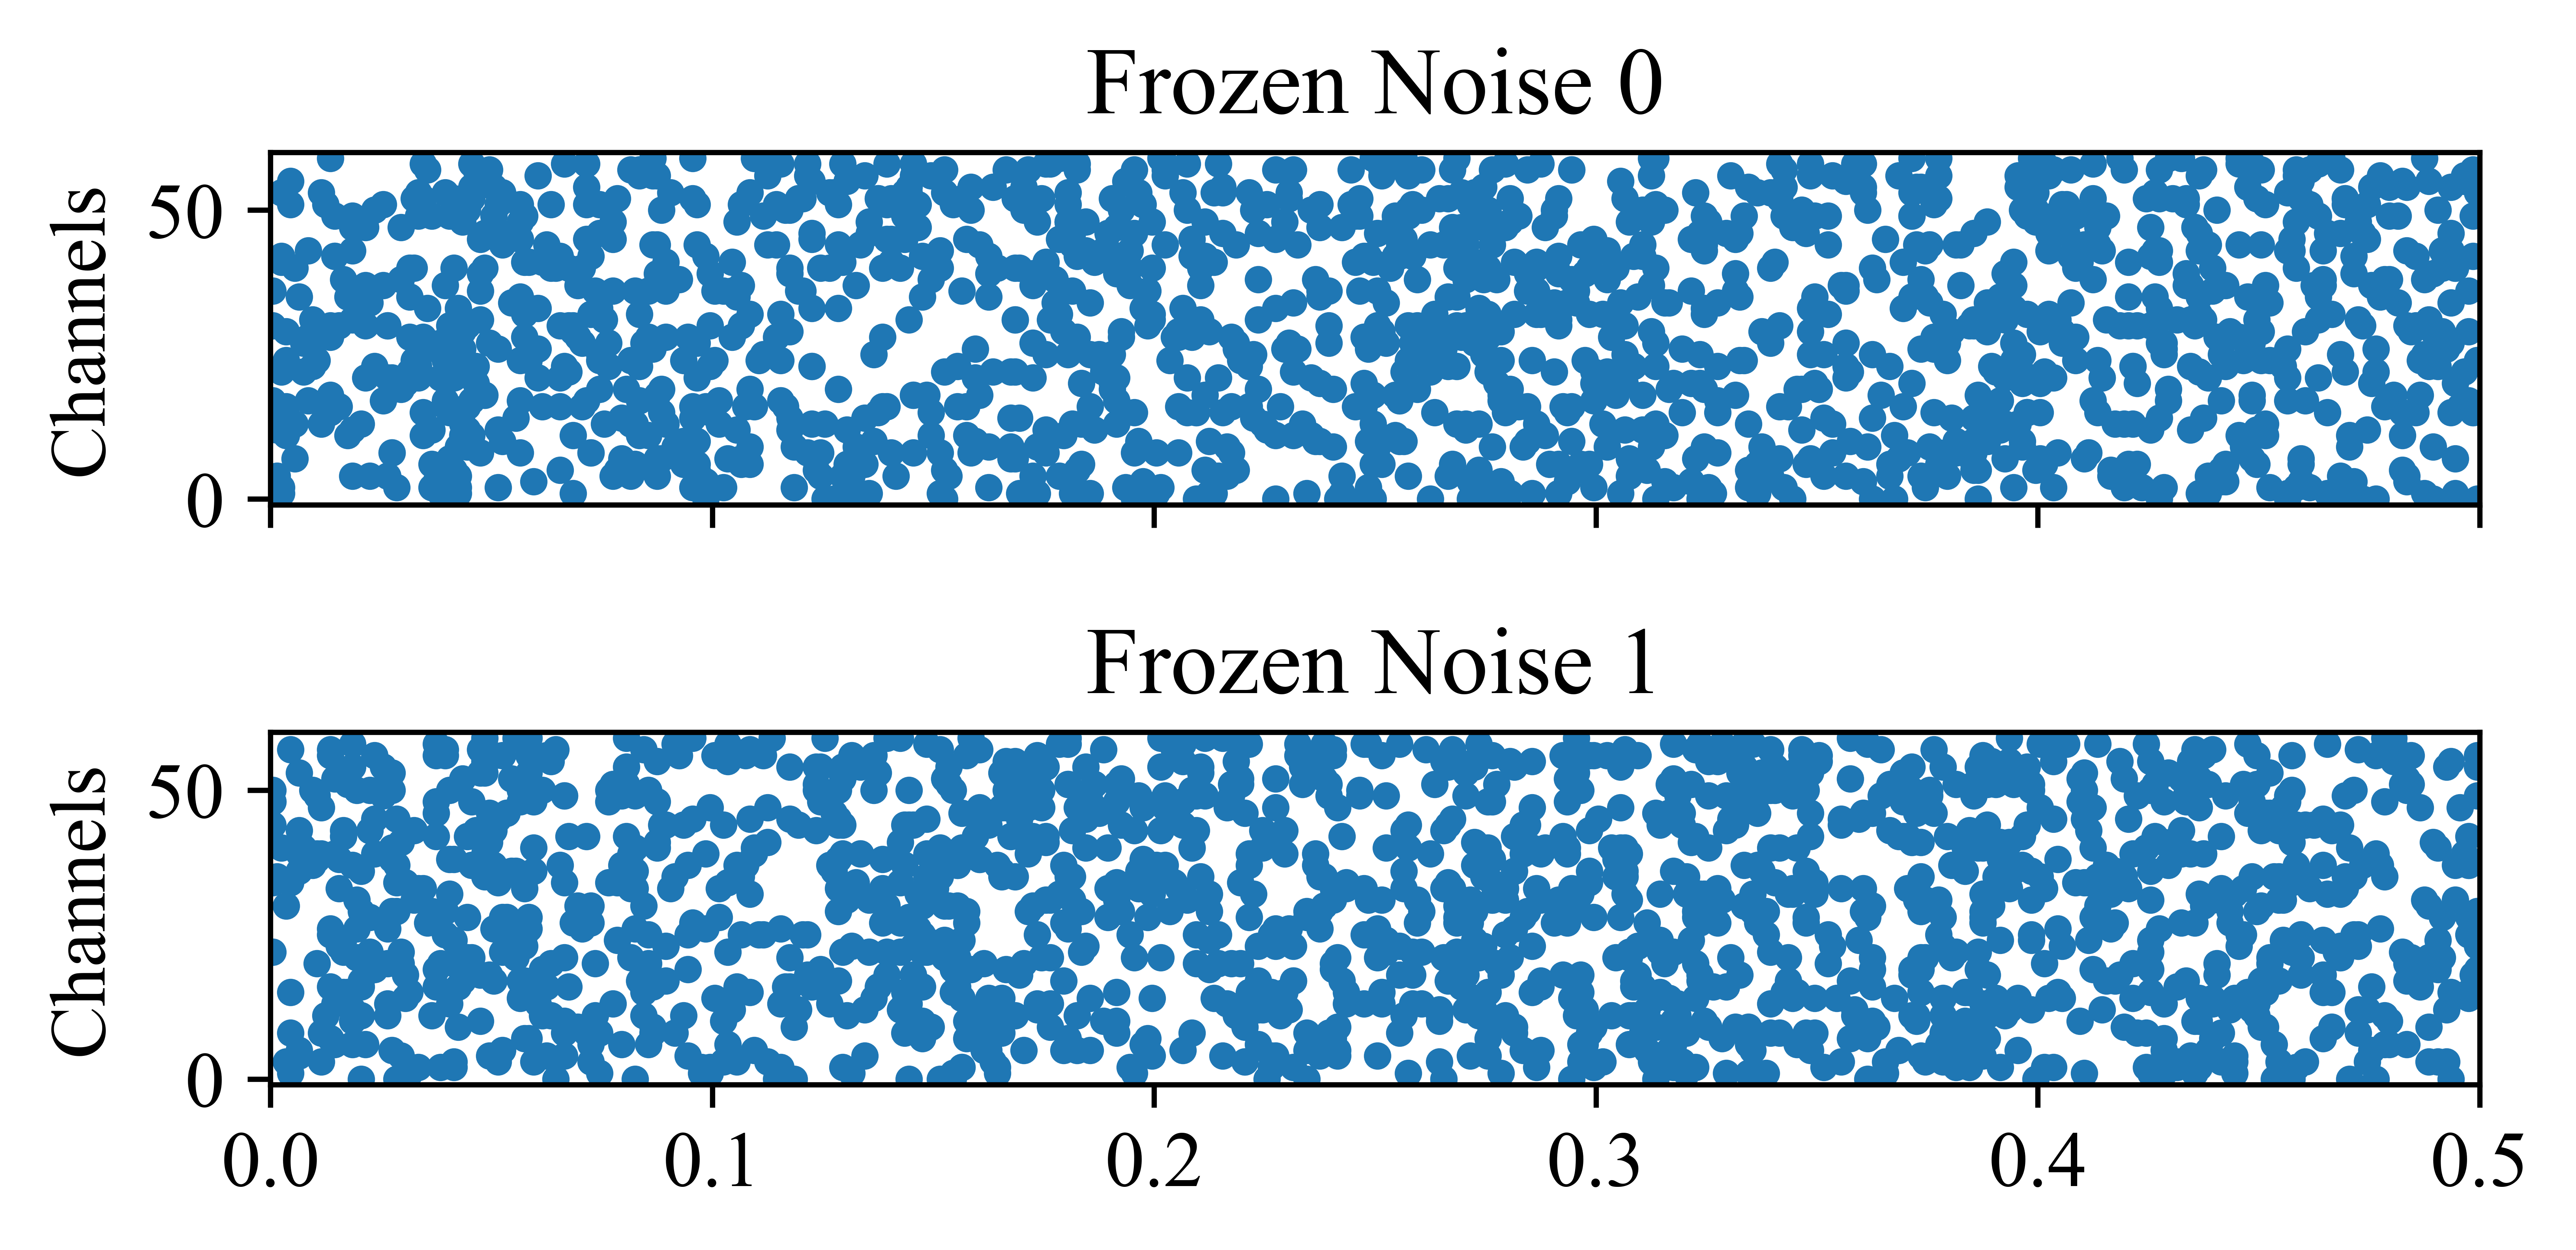

In [3]:
train_data.plot_samples(adjust_size=False)

## Step 2 : Network Configuration

Using the simulation configuration object, create a dynapse simulator

In [4]:
Nin = train_data.n_in
Nrec = train_data.n_out

In [5]:
# --- Input Layer --- #
linear_in = LinearJax(shape=(Nin, Nrec), has_bias=False)
linear_in


LinearJax  with shape (60, 2)

In [6]:
# --- DynapSim Layer --- #
dynapsim = DynapSim((Nrec, Nrec), Iscale=1e-7, has_rec=True, percent_mismatch=0.05)
dynapsim


DynapSim  with shape (2, 2)

In [7]:
model = Sequential(linear_in, dynapsim)
model

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

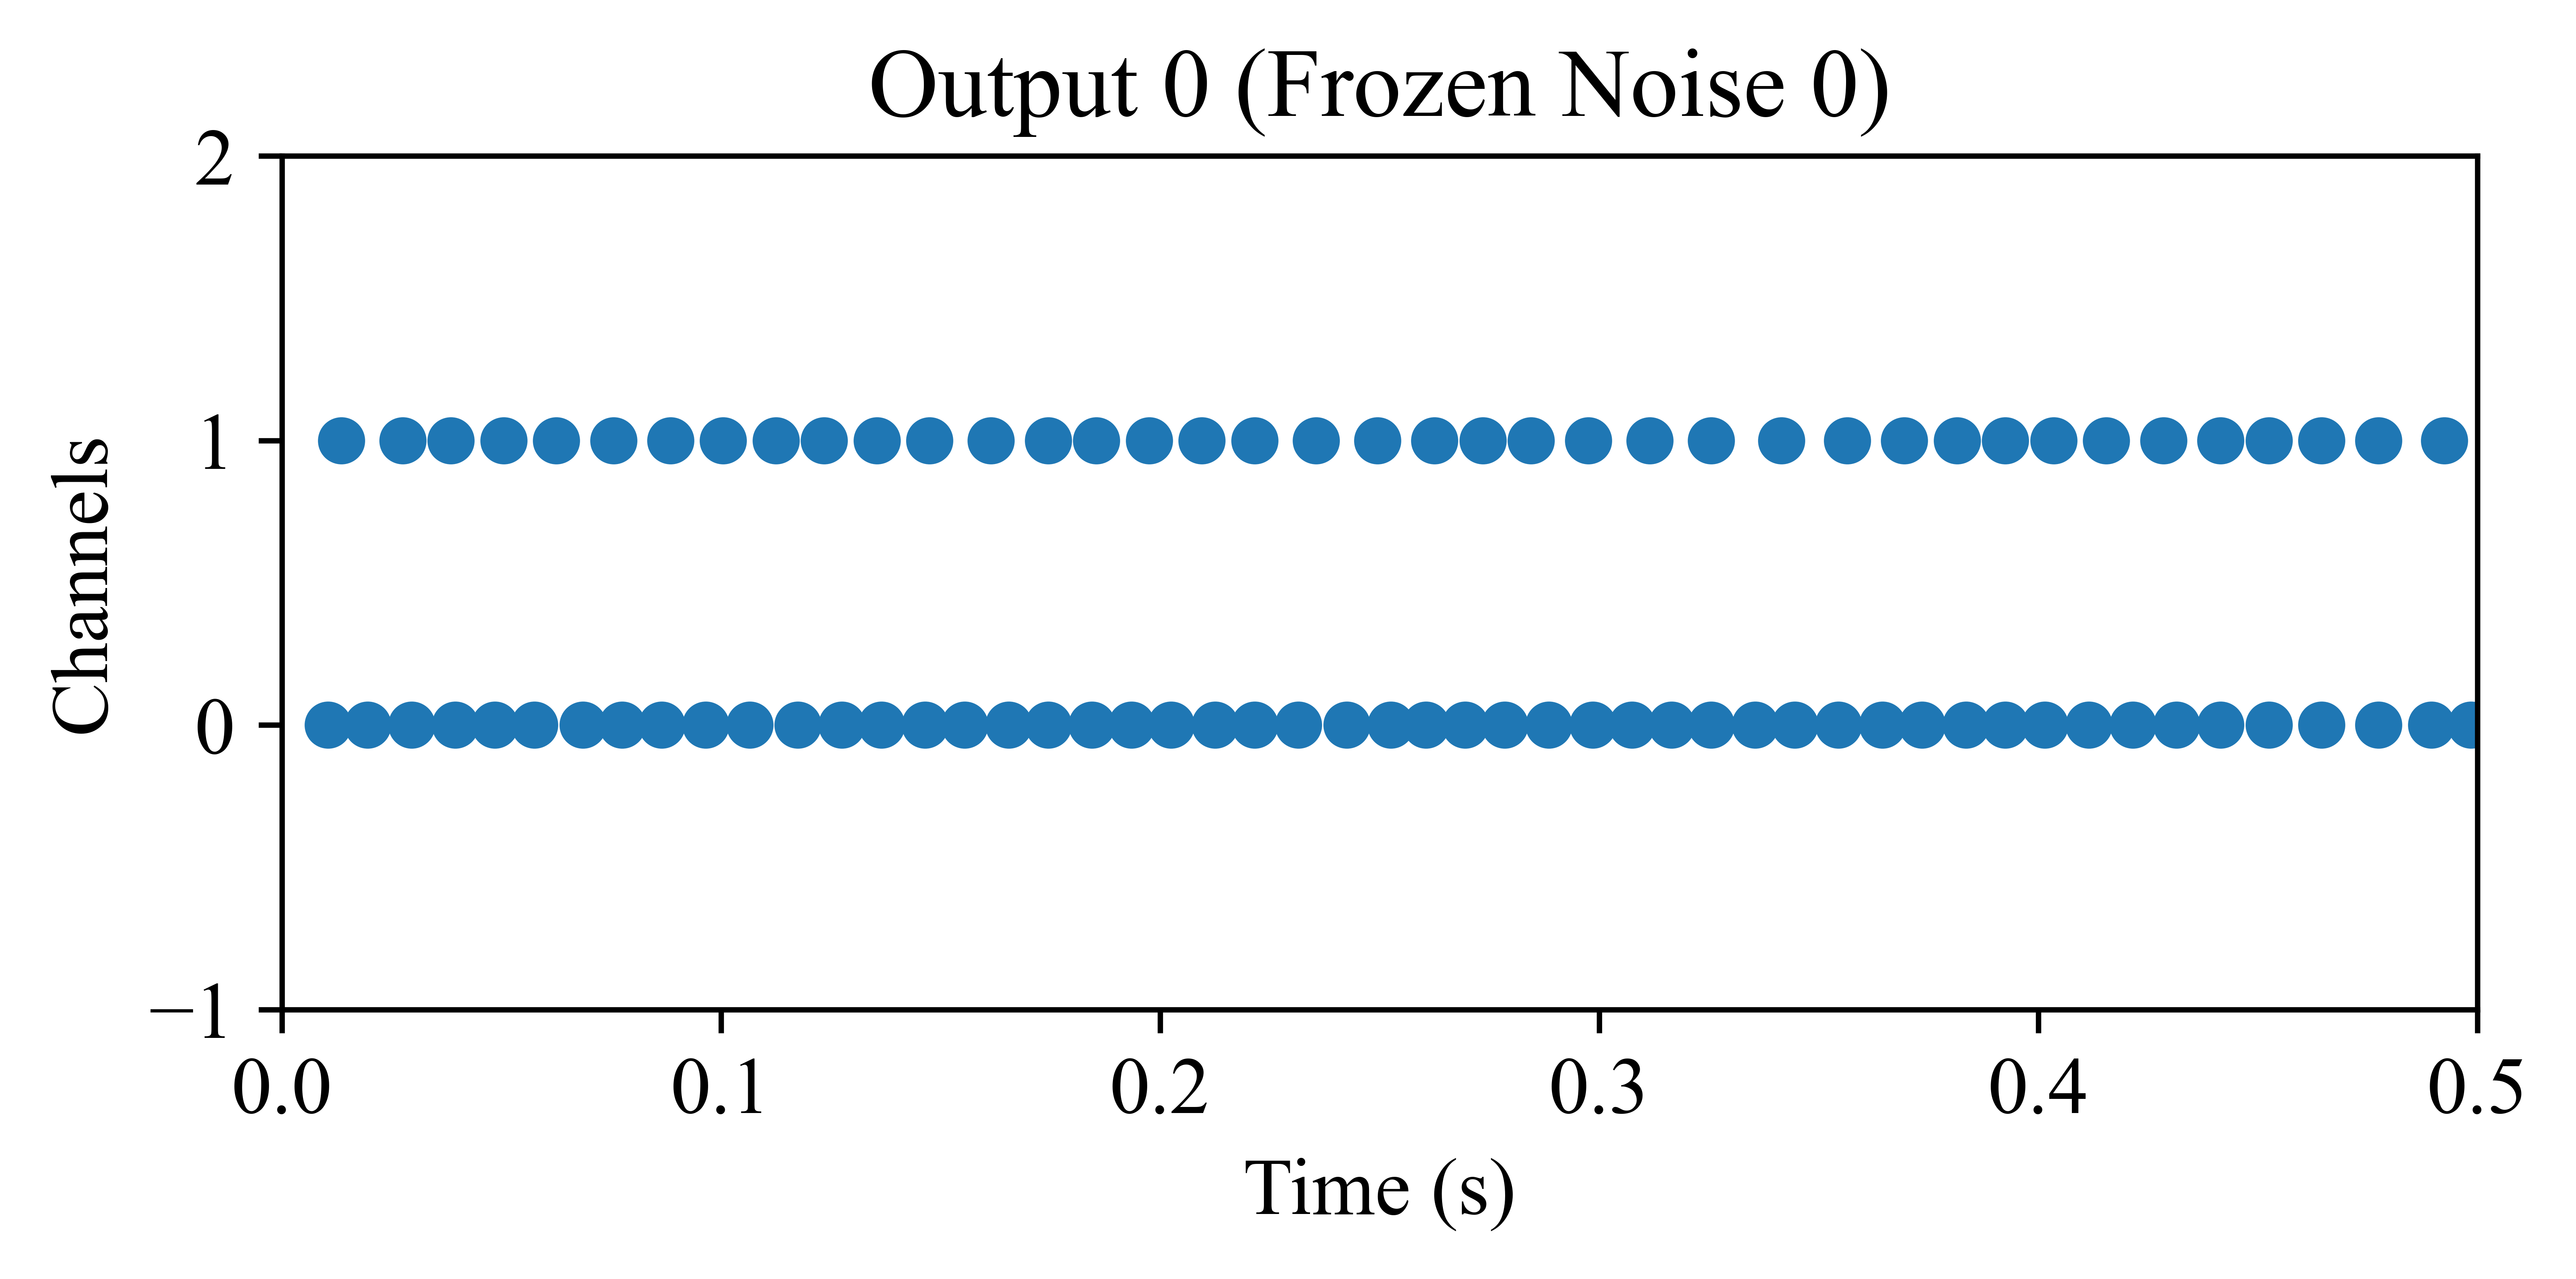

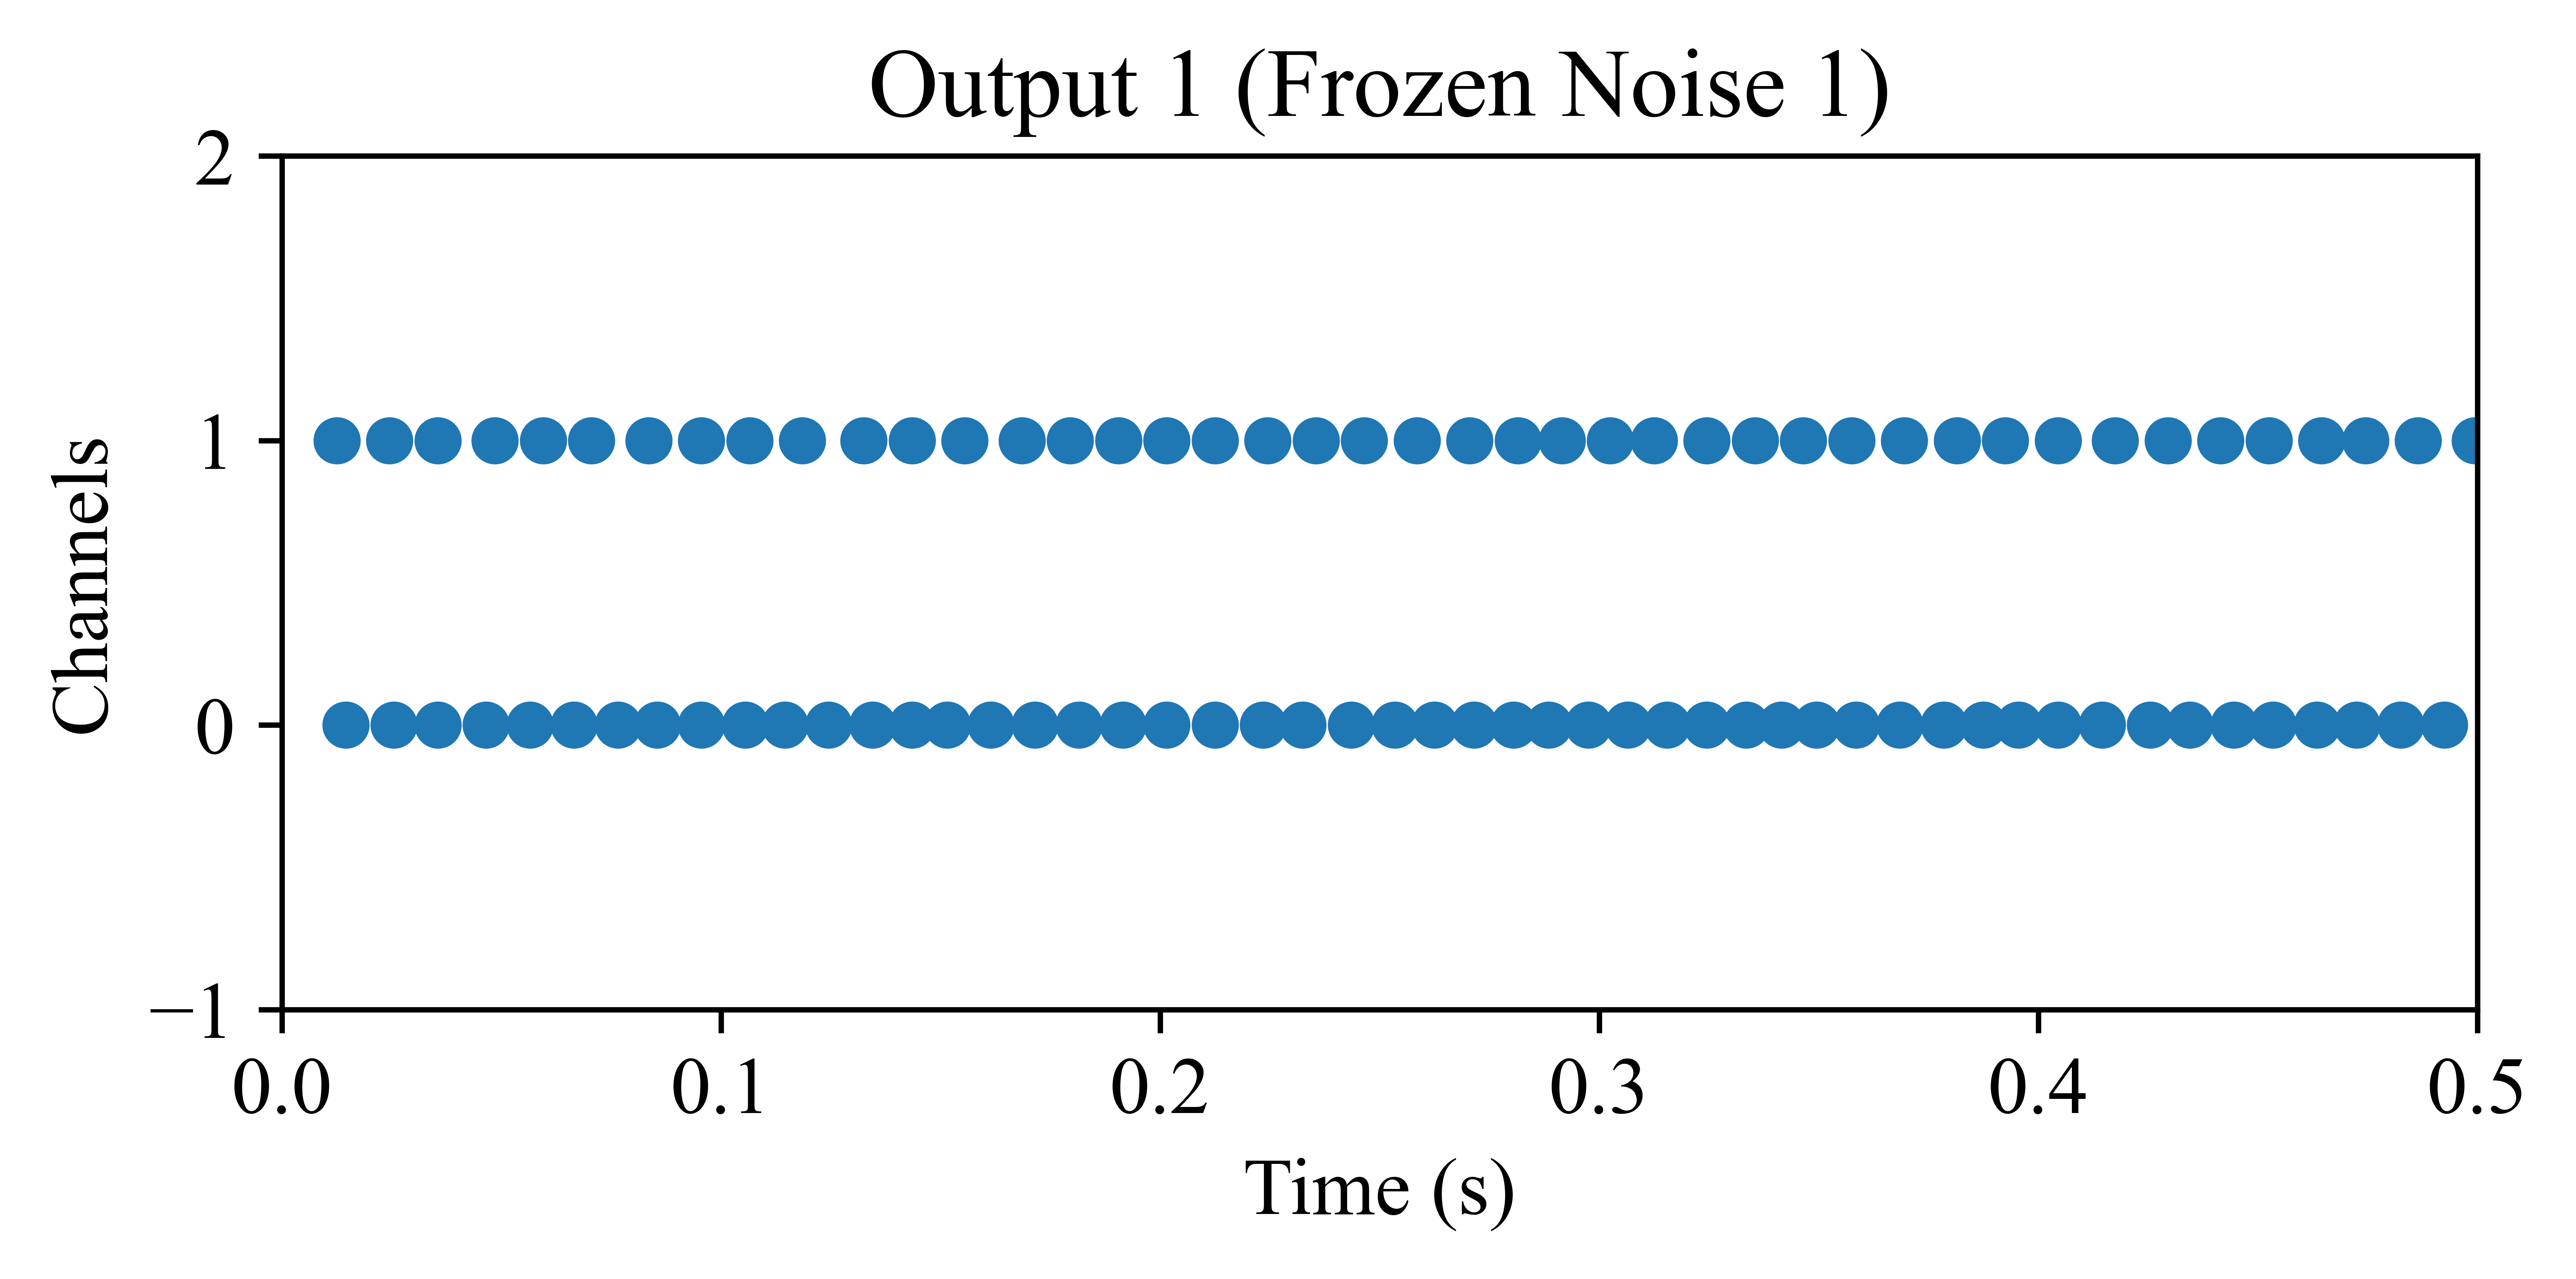

In [8]:
rec_init = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model.reset_state()
    out, _, rec = model(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

## Step 3 : Optimization

In [9]:
# - Jax imports
import jax
from jax.experimental.optimizers import adam
from rockpool.training import jax_loss as jl


## Optimizer

In [10]:
# - Initialise optimiser
learning_rate = 1e-2

init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(model.parameters())
update_fun = jax.jit(update_fun)

## Loss Function

In [11]:
# - Loss function
@jax.jit
@jax.value_and_grad
def loss_vgf(params, net, input, target):
    net = net.set_attributes(params)
    net = net.reset_state()
    output, _, _ = net(input)
    return jl.mse(output, target)

## Mismatch Generator (Optional)

In [12]:
percent_deviation = 0.30
sigma_rule = 3.0
rng_key = jnp.array([2021, 2022], dtype=jnp.uint32)

regenerate_mismatch = dynapse_mismatch_generator(percent_deviation, sigma_rule)
regenerate_mismatch = jax.jit(regenerate_mismatch)

## Batch Data

In [13]:
batch_input, batch_target  = train_data[:,:,:]

In [14]:
# - Configure learning
num_epochs = int(1.5e5)
apply_mismatch = False

sim_param = model.simulation_parameters()
loss_t = []
# - Training loop
t = tqdm(range(num_epochs), desc='Training', unit='Epoch', total=num_epochs)
    
for epoch in t:
    # - Get parameters
    opt_parameters = get_params(opt_state)

    # - Regenerate mismatch
    if apply_mismatch and epoch%100 == 0:
        rng_key, _ = rand.split(rng_key)
        new_params = regenerate_mismatch(sim_param, rng_key=rng_key)
        model = model.set_attributes(new_params)

    # - Compute loss and gradient
    l, g = loss_vgf(opt_parameters, model, batch_input, batch_target)
    loss_t.append(l.item())
    t.set_postfix({'loss': l.item()}, refresh = False)

    # - Update optimiser
    opt_state = update_fun(epoch, g, opt_state)

Training: 100%|██████████| 150000/150000 [00:50<00:00, 2972.11Epoch/s, loss=0.46] 


## Plot Loss

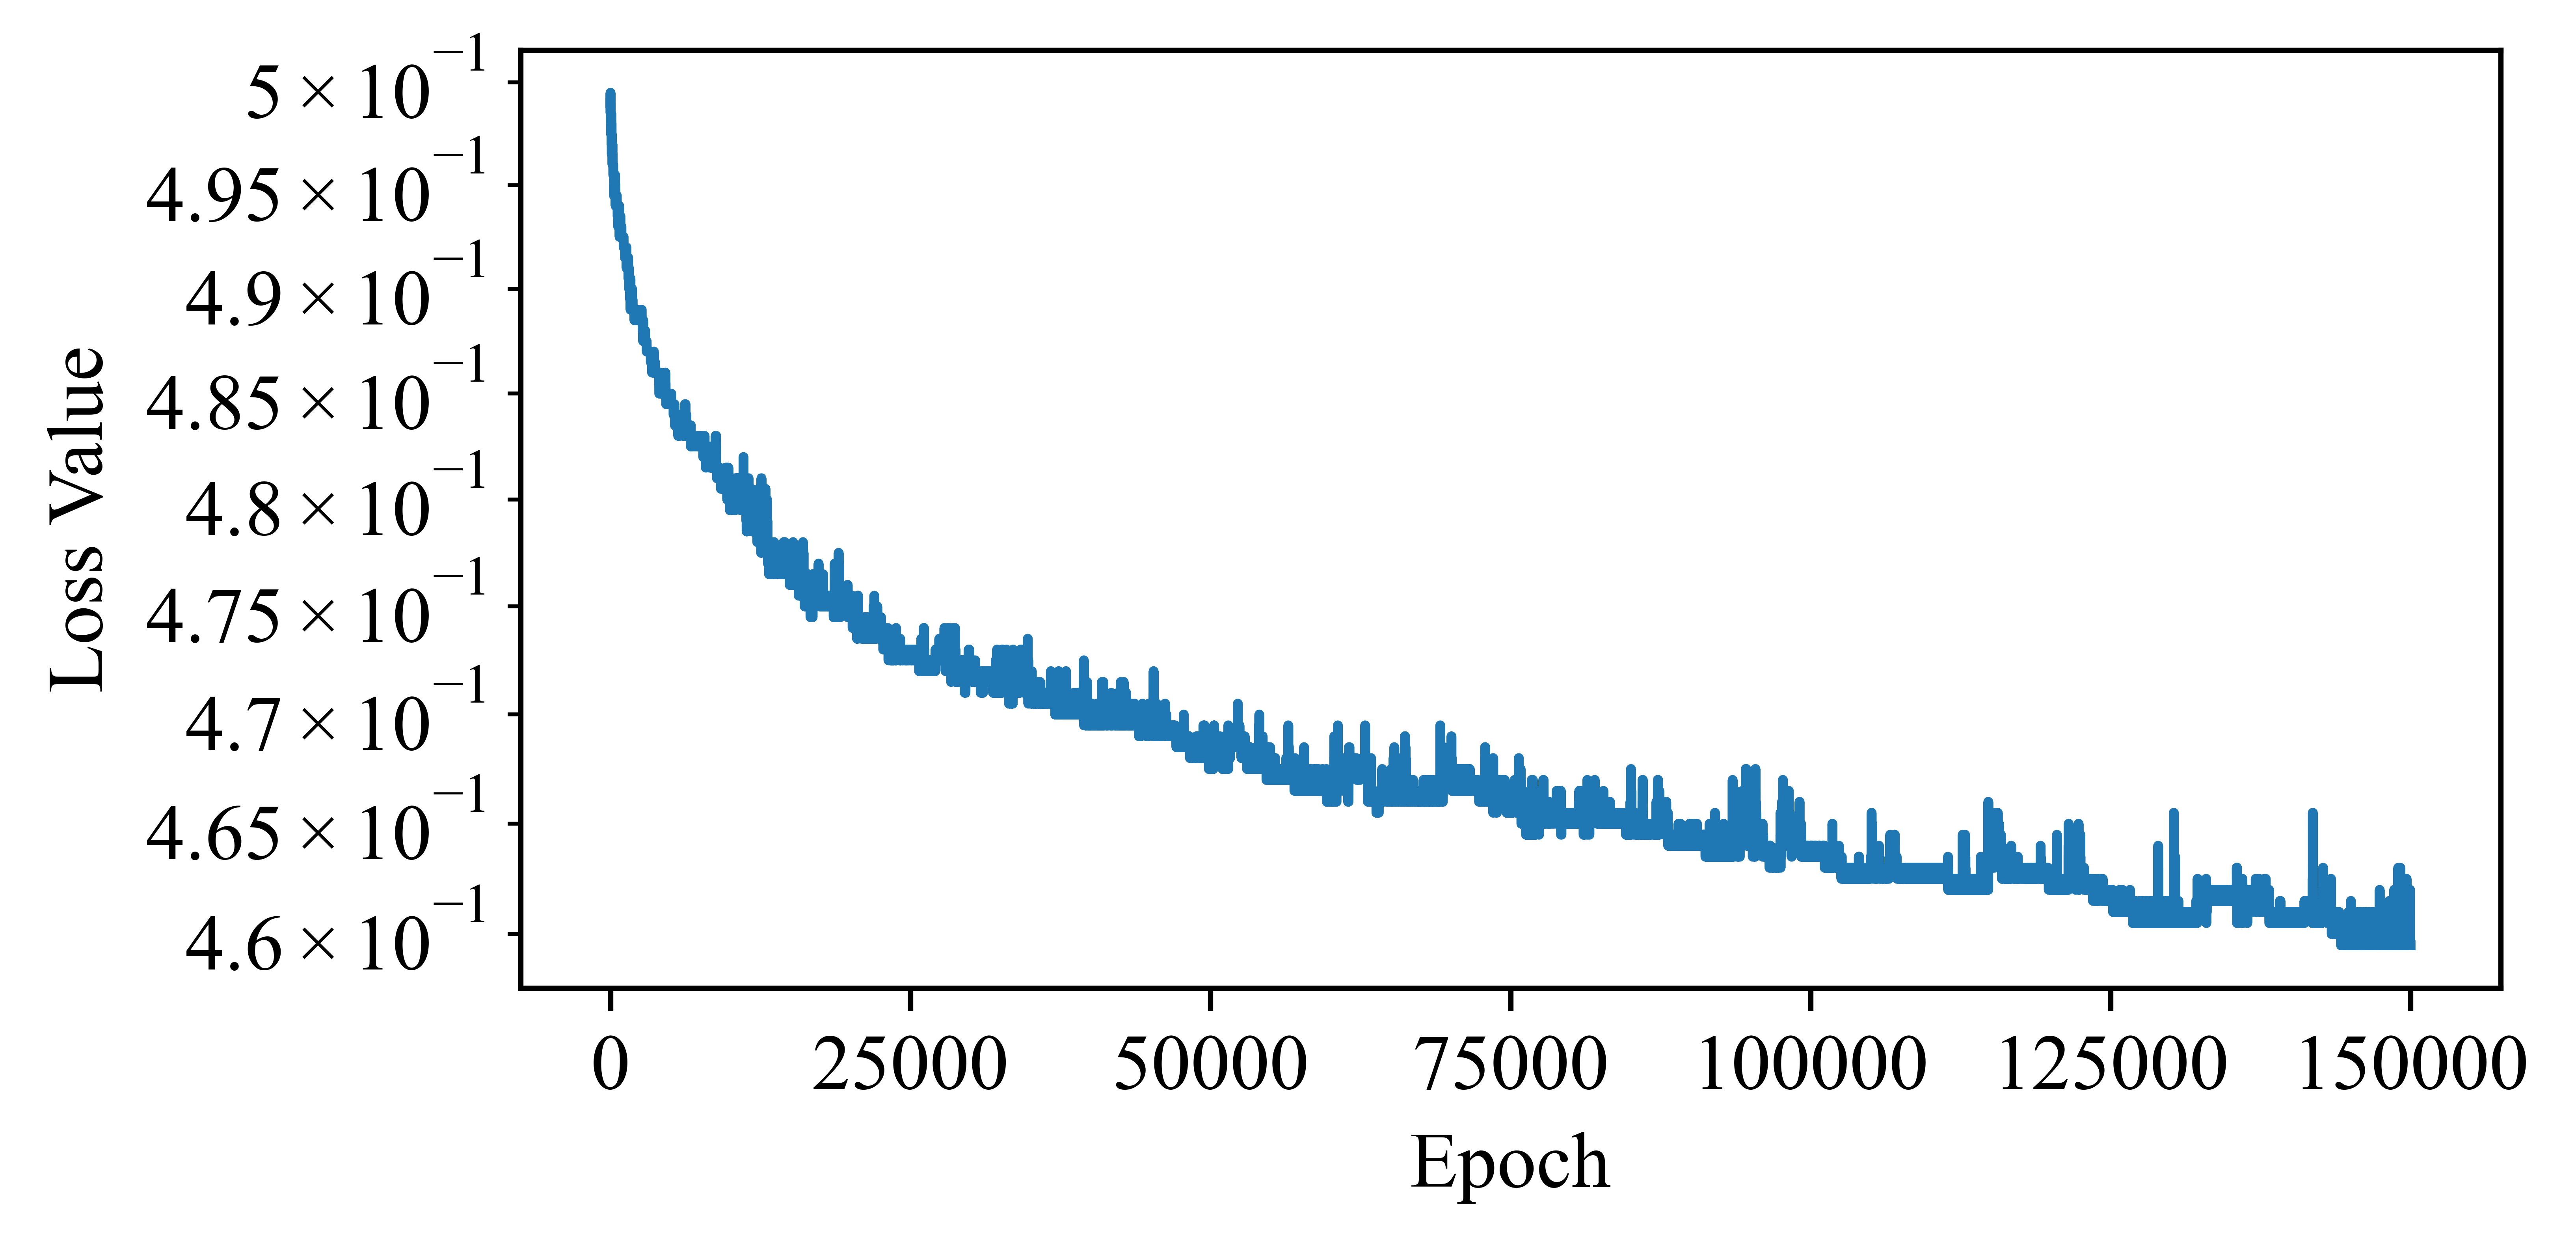

In [15]:
plt.semilogy(loss_t)
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.tight_layout()

In [16]:
model_optimized = model.set_attributes(get_params(opt_state))

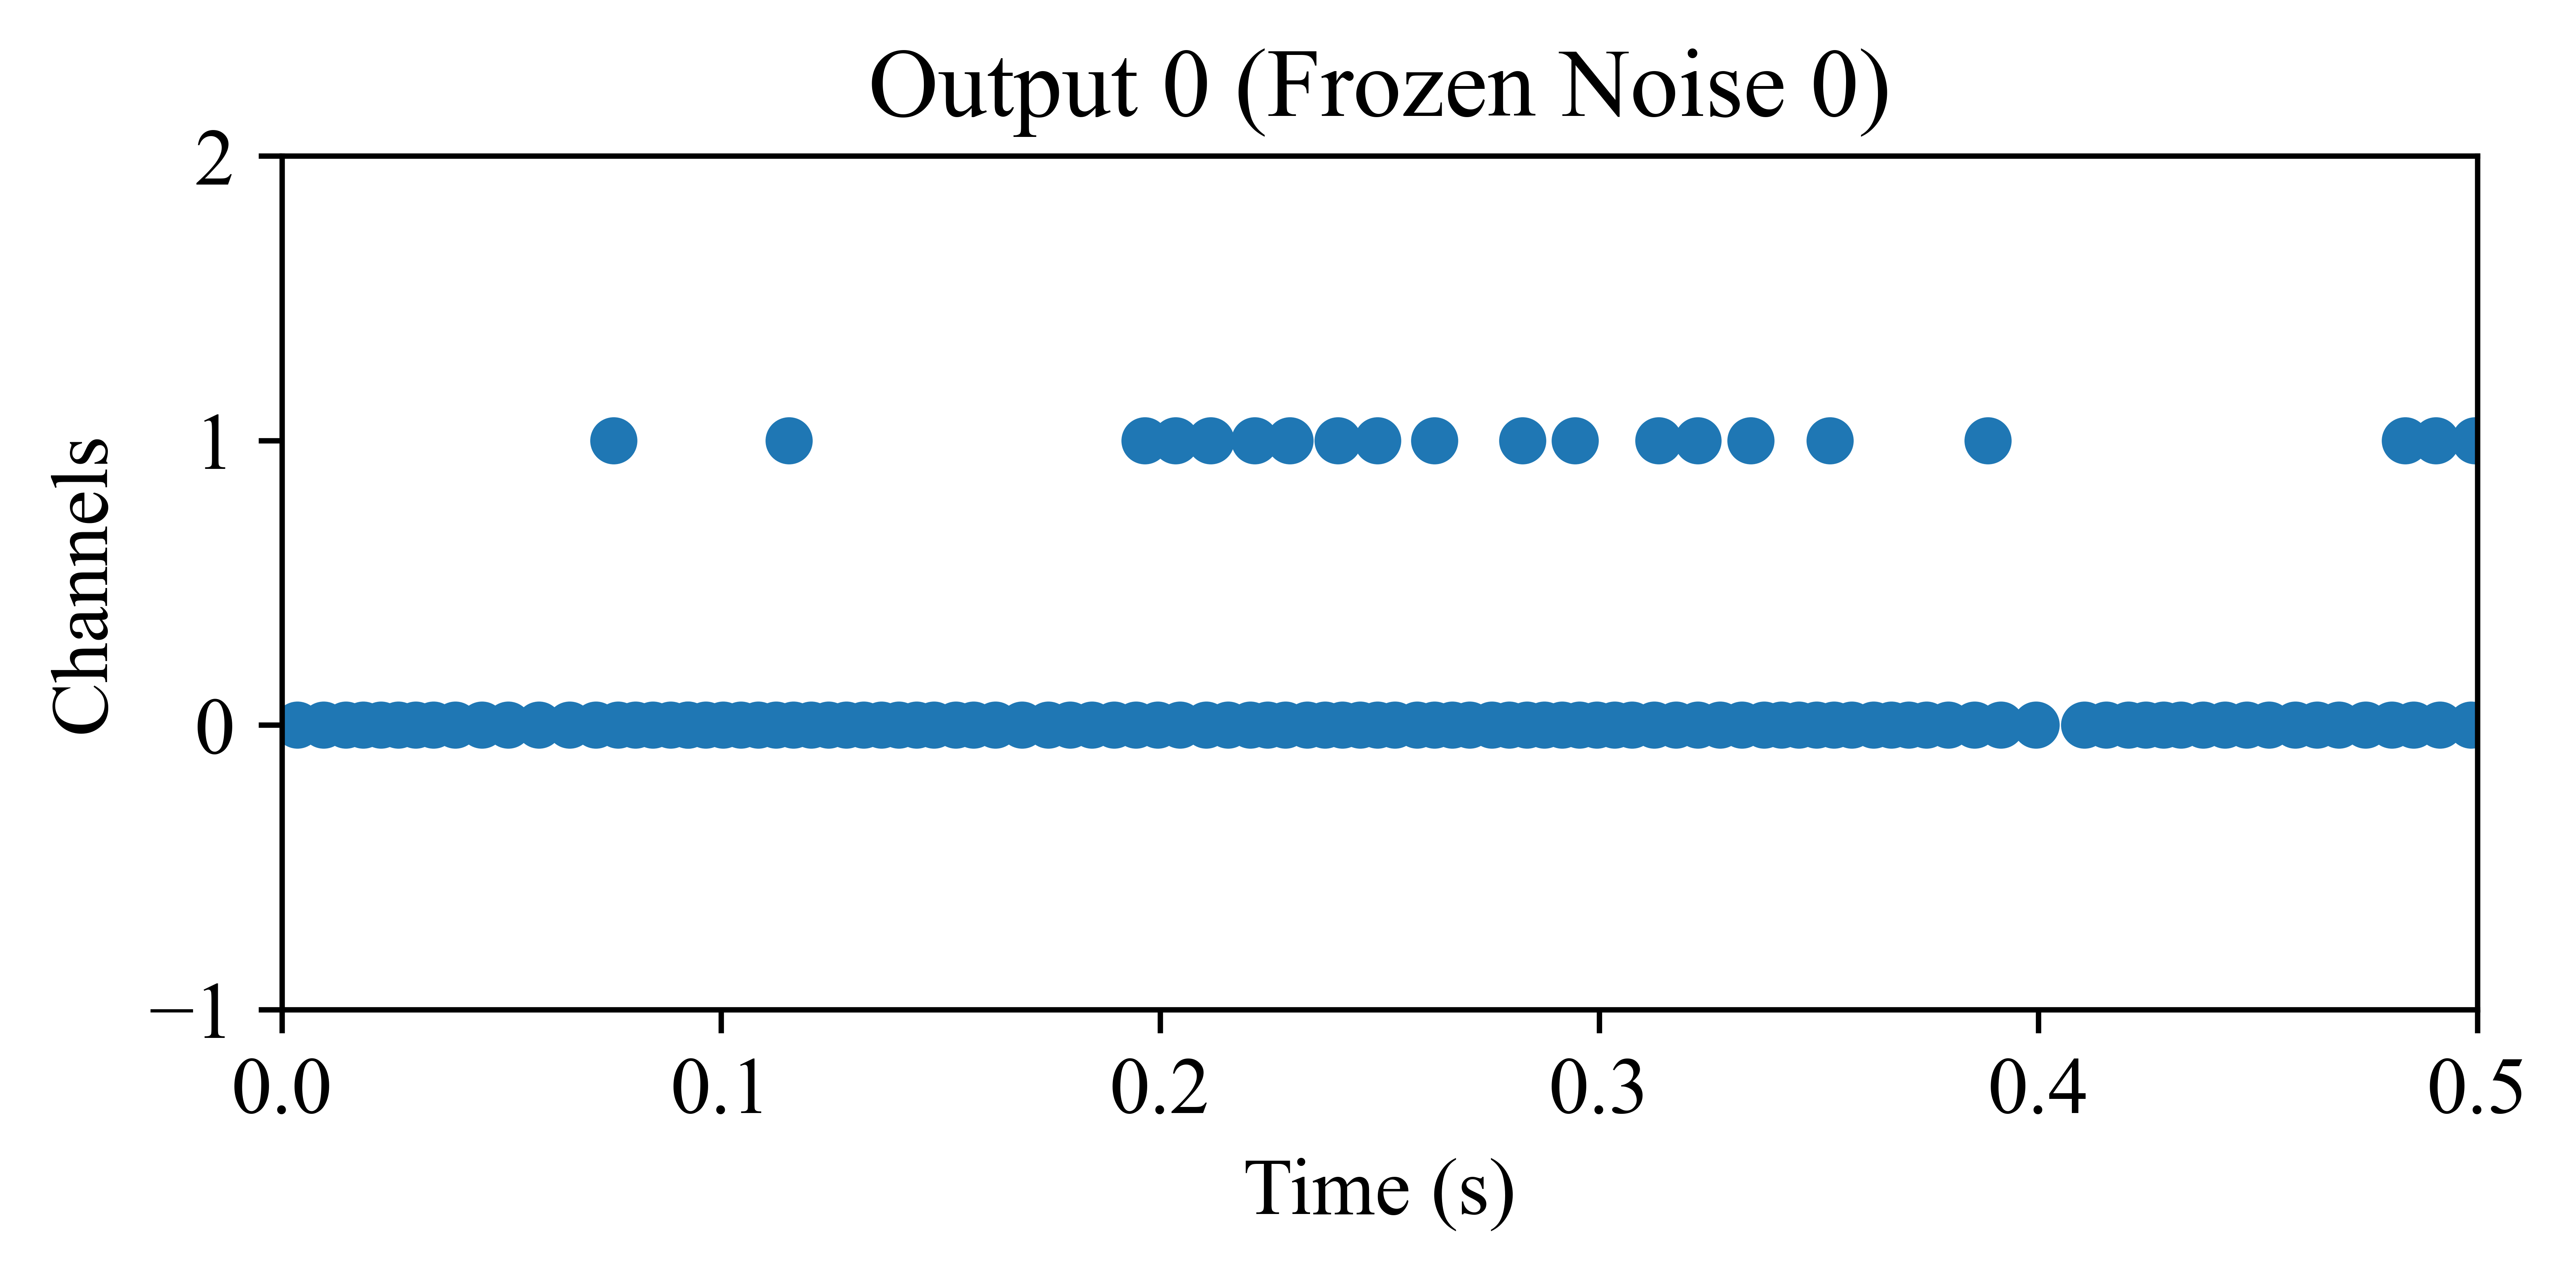

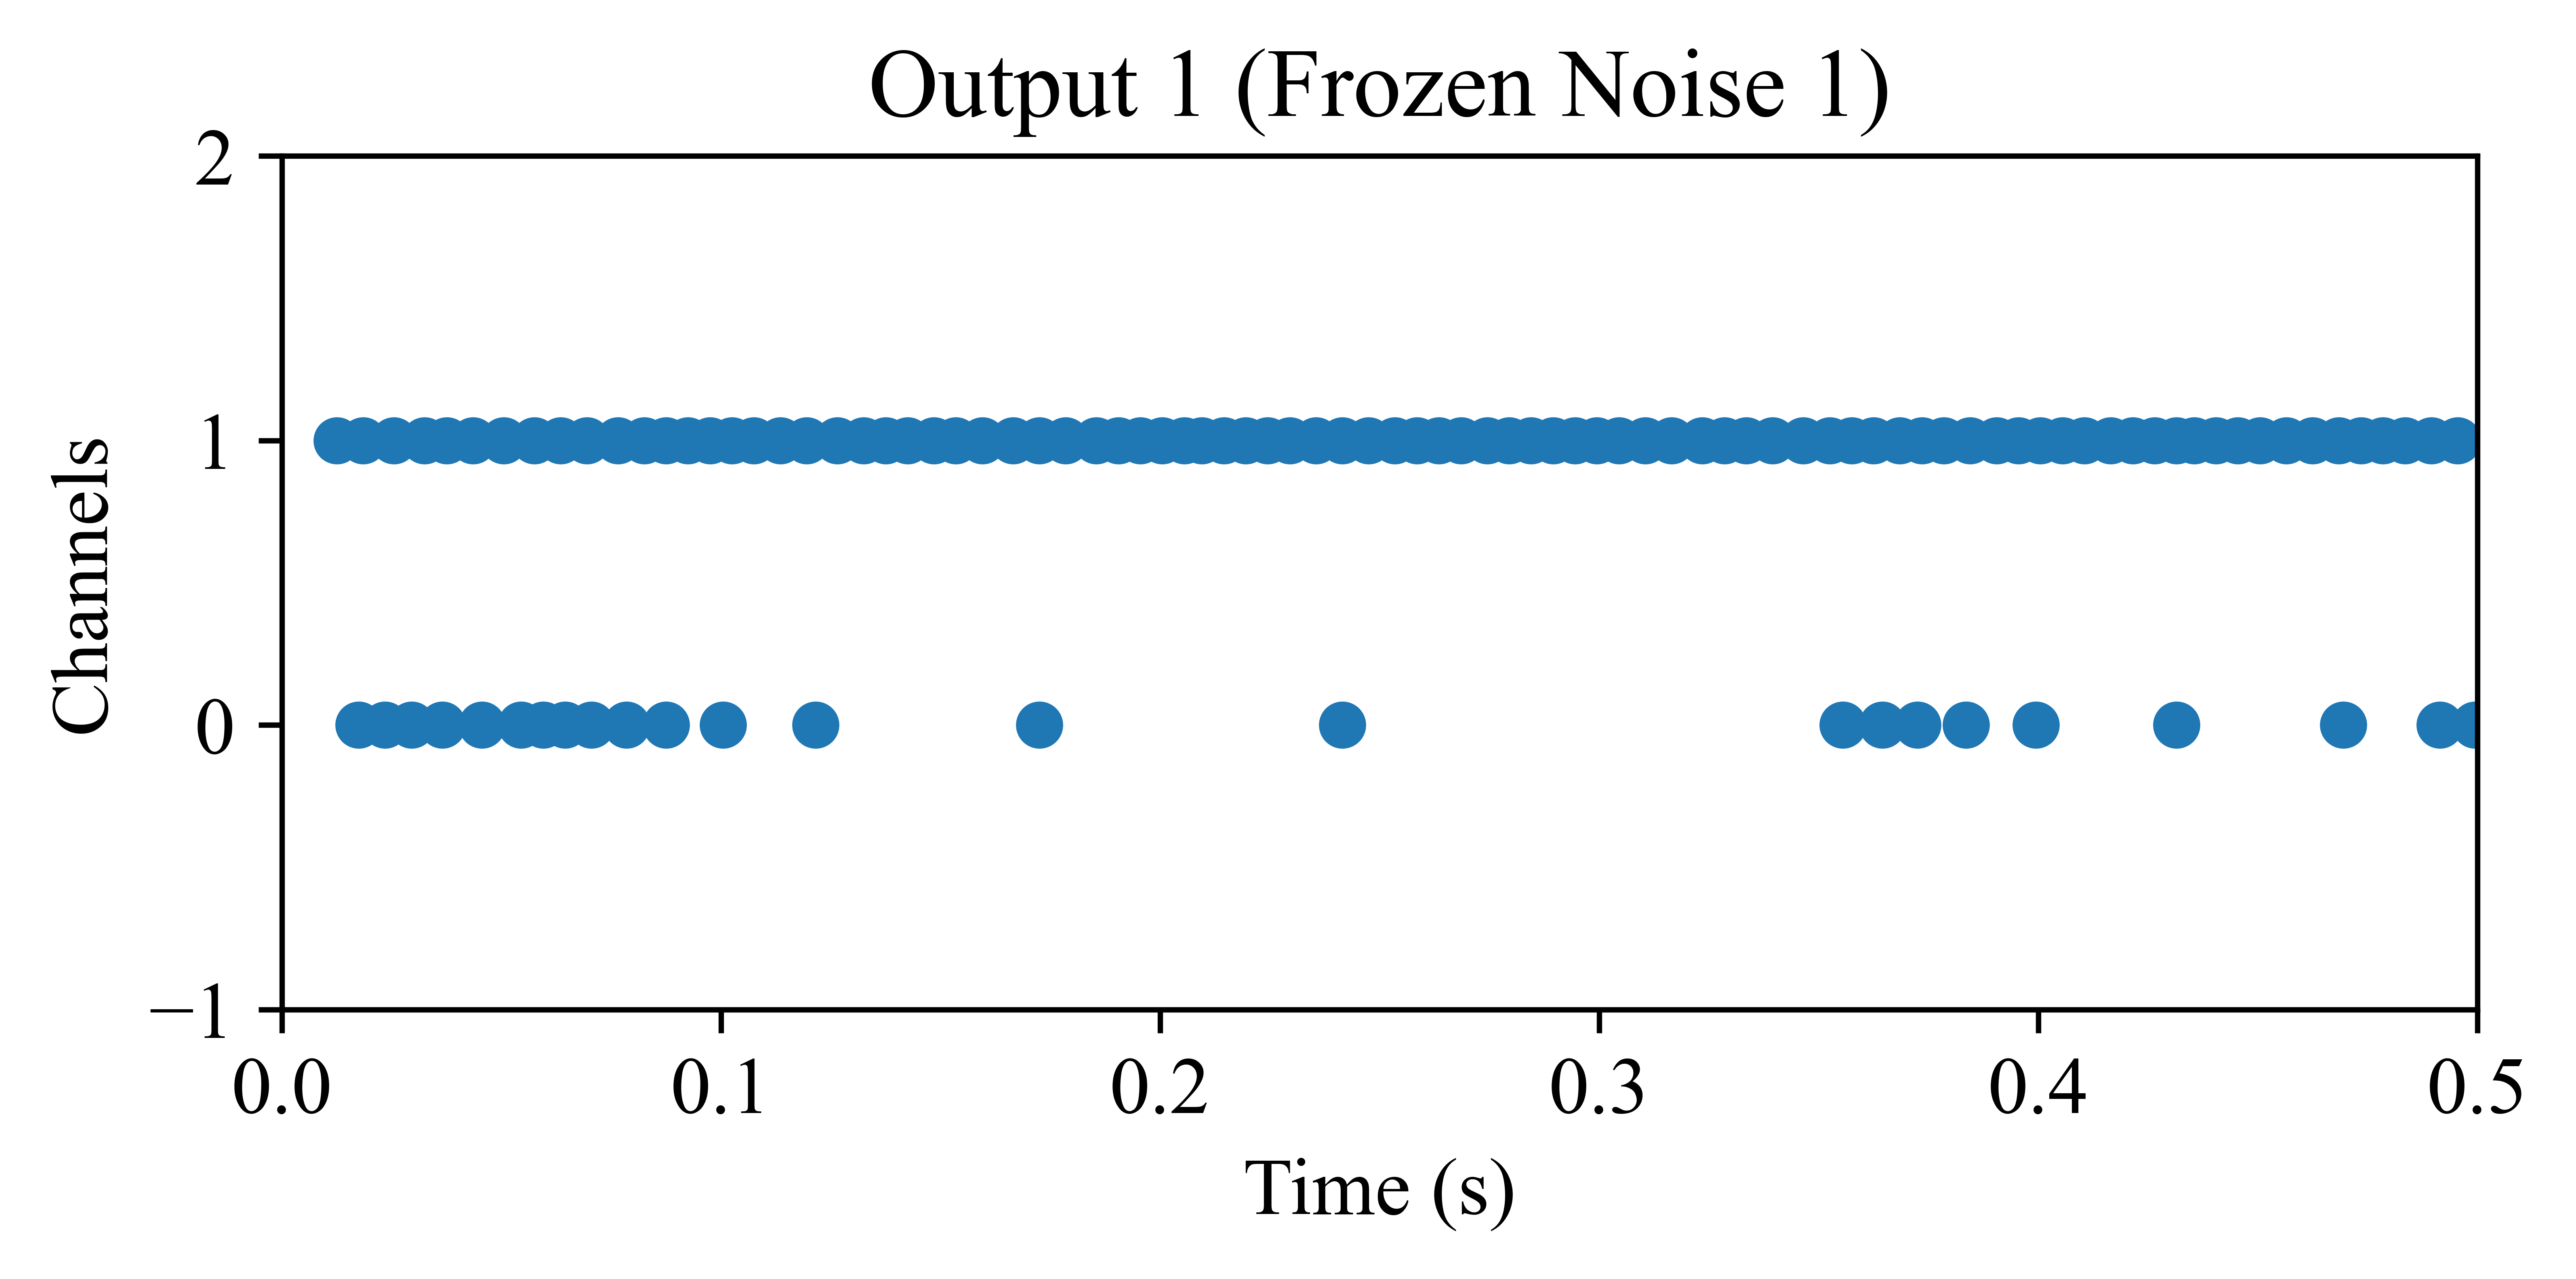

In [17]:
rec_optimized = []
for i in range(len(train_data)):
    plt.figure()
    inp, target = train_data[i]
    model_optimized.reset_state()
    out, _, rec = model_optimized(inp)
    rec_init.append(rec)
    output = TSEvent.from_raster(out[0], dt=1e-3, name=f"Output {i} (Frozen Noise {i})").plot()
    plt.tight_layout()

In [18]:
save_params = True
if save_params:
    p0, p1 = get_params(opt_state).values()

    with open("data/w_in_optimized.npy", "wb") as f:
        np.save(f, p0["weight"])

    with open("data/w_rec_optimized.npy", "wb") as f:
        np.save(f, p1["w_rec"])